| | |
|:----------|:----------|
| Name      | Bayesian Modeling |
| Notebook  | Switch Point Model |
| Author    | Joshuah Touyz, PhD |
| Version   | 0.1 |
|Last update| 11/10/20 |

In [1]:
# _ Libraries - 
import pandas as pd
import numpy as np
import plotnine as pn

# - Options -
pn.options.figure_size = (10,5)
np.random.seed(1234)

In [2]:
# Setting up constants
alpha = 10; beta = 0.1
k = 7000 # iterations

In [3]:
# Generating true process
l1_true = 10
l2_true = 15
n_true = 20; N = 80

In [4]:
# Generating the process 
y = np.concatenate([np.random.poisson(l1_true, size = n_true),
                    np.random.poisson(l2_true, size = N-n_true)])

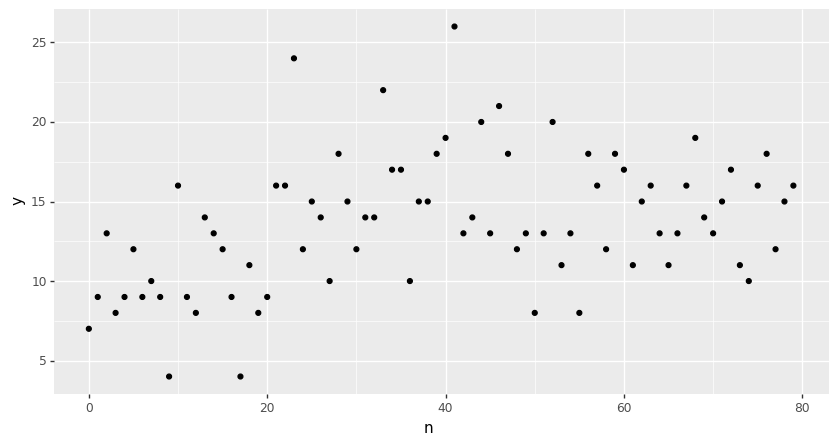

<ggplot: (-9223372036535709496)>

In [5]:
# Lets plot the data first
pn.ggplot(pn.aes(x = 'n', y = 'y'), data = pd.DataFrame({'y':y, 'n':np.arange(0,N)})) + pn.geom_point()

In [6]:
# Setting up the utility functions
rgamma = lambda a, b: np.random.gamma(shape = a, scale=1/b, size=1)
log_n_p_kernel = lambda y_in, n_in, l_1, l_2: np.sum(y_in[:n_in]) * np.log(l_1)\
                                           + np.sum(y_in[n_in:]) * np.log(l_2)\
                                           - (n_in * l_1 + (N - n_in) * l_2)

In [7]:
# Setting up posterior for n
def post_n(y_in,l1,l2):
    log_p_n = np.array([log_n_p_kernel(y_in,ii,l1,l2) for ii in range(0,N)]) # over all values of n
    log_p_n = log_p_n - np.max(log_p_n) # trick to normalize values and prevent overflow/underflow errors
    p = np.exp(log_p_n)/(np.exp(log_p_n).sum()) # getting the probability
    out = np.random.choice(range(0,N), size = 1, p = p)[0] # getting the first element
    return(out)

In [8]:
# Pre-allocating the vector
lambda_1 = np.zeros(k) ; lambda_2 = np.zeros(k)
n = np.zeros(k).astype('int')
lambda_1[0] = lambda_2[0] = np.mean(y)
n[0] = 30

In [9]:
# Setting up the sampler
for i in range(1,k):
    y_in_1 = np.sum(y[:n[i-1]]) 
    y_in_2 = np.sum(y[n[i-1]:])
    lambda_1[i] = rgamma(alpha+y_in_1, n[i-1] + beta)
    lambda_2[i] = rgamma(alpha + y_in_2, (N-n[i-1]) +beta)
    n[i] = post_n(y, lambda_1[i], lambda_2[i])

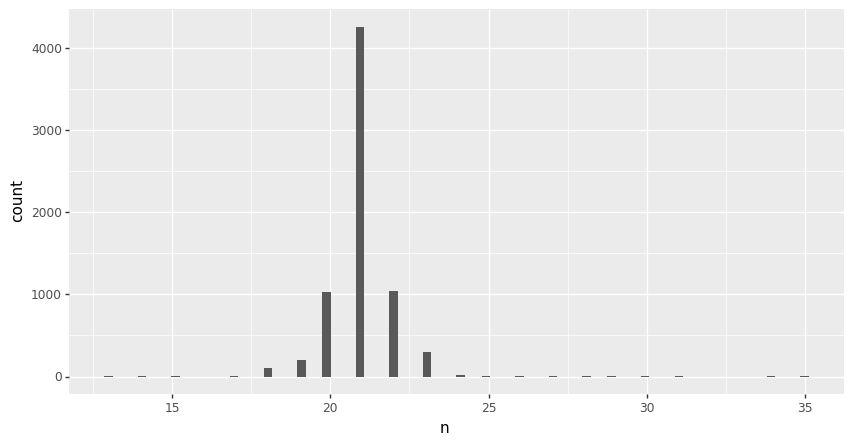

<ggplot: (-9223372036533477337)>

In [10]:
# Most likely switch point
pn.ggplot(pn.aes(x = 'n'), data = pd.DataFrame({'n':n})) + pn.geom_histogram()

The estimated value for n is 21.02


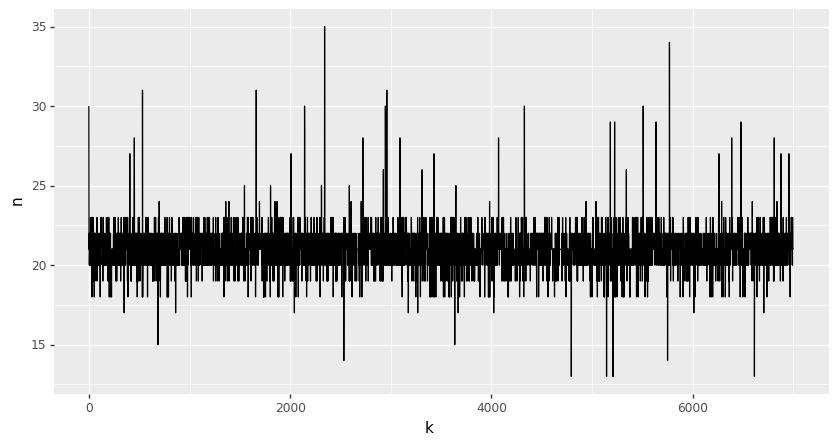

<ggplot: (-9223372036533446382)>

In [11]:
# Trace of n
print('The estimated value for n is {}'.format(np.round(n.mean(),2)))
pn.ggplot(pn.aes(x = 'k', y = 'n'), pd.DataFrame({'k':np.arange(0,k), 'lambda_1':lambda_1})) + pn.geom_line()

The estimated value for lambda_1 is 10.18


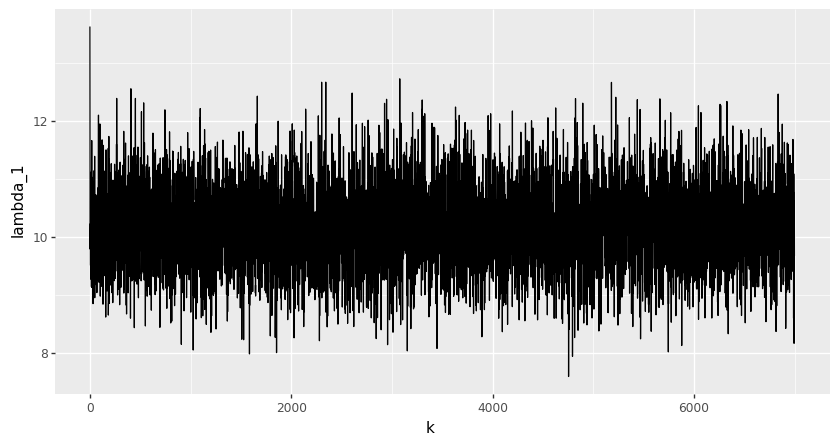

<ggplot: (321340473)>

In [12]:
# Trace of lambda 1
print('The estimated value for lambda_1 is {}'.format(np.round(lambda_1.mean(),2)))
pn.ggplot(pn.aes(x = 'k', y = 'lambda_1'), pd.DataFrame({'k':np.arange(0,k), 'lambda_1':lambda_1})) + pn.geom_line()

The estimated value for lambda_2 is 15.17


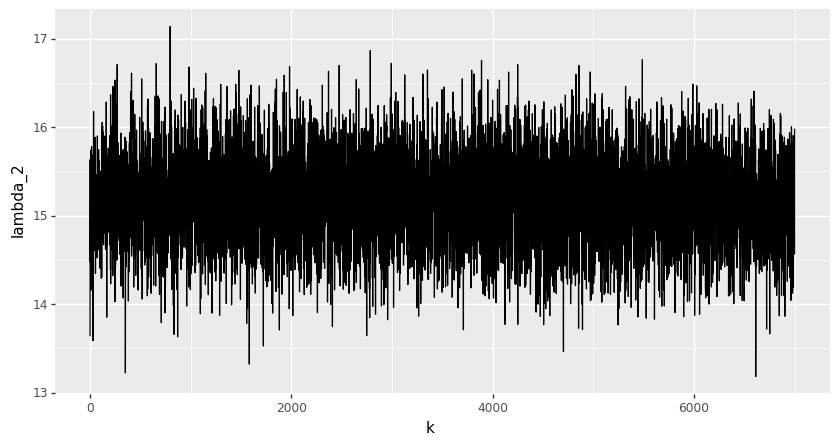

<ggplot: (321340585)>

In [13]:
# Trace of lambda 2
print('The estimated value for lambda_2 is {}'.format(np.round(lambda_2.mean(),2)))
pn.ggplot(pn.aes(x = 'k', y = 'lambda_2'), pd.DataFrame({'k':np.arange(0,k), 'lambda_2':lambda_2})) + pn.geom_line()

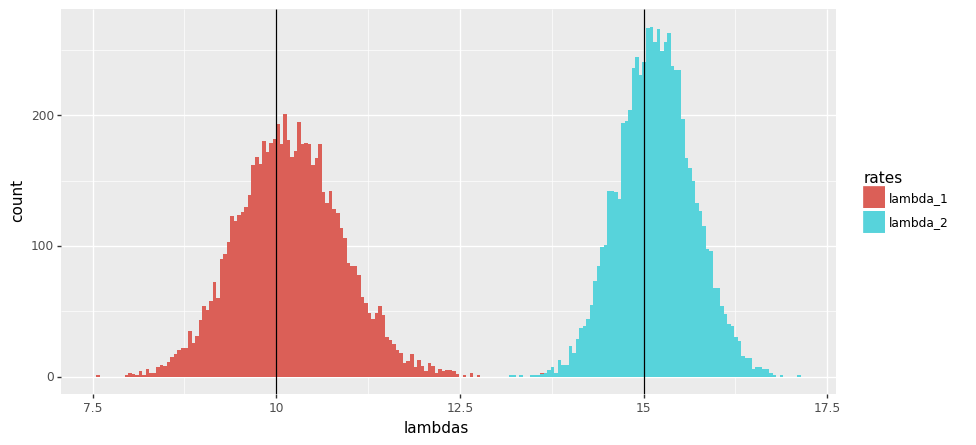

<ggplot: (321396537)>

In [14]:
# Plotting the two graphs together
lambdas = np.concatenate([lambda_1, lambda_2])
rates = ['lambda_1'] * k + ['lambda_2'] * k
data_in = pd.DataFrame({'lambdas':lambdas, 'rates':rates})

pn.ggplot(pn.aes(x = 'lambdas', fill = 'rates'), data = data_in)\
    + pn.geom_histogram(bins = 200)\
    + pn.geom_vline(pn.aes(xintercept = 10))\
    + pn.geom_vline(pn.aes(xintercept = 15))